# Hilo GeoJson Exploration for Yelp API Scrape

In [1]:
#opening libraries
import pandas as pd
import json
import geopandas as gpd


with open('../data/boundaries/hilo.geojson') as f:
    hilo = json.load(f)


fname = '../data/boundaries/hilo.geojson'
hilo_gpd = gpd.read_file(fname)

### Using Shapely LineString

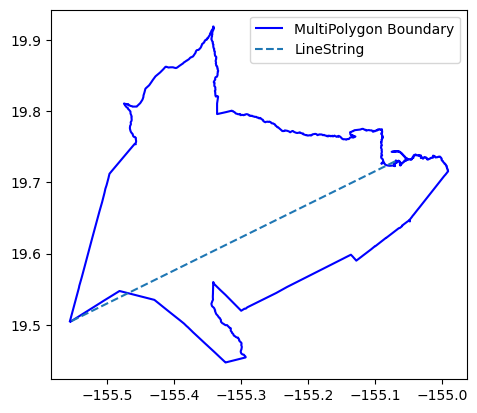

In [2]:
from shapely.geometry import LineString, MultiPolygon
import matplotlib.pyplot as plt
import geopandas as gpd


#### example 


#took random points from file
line_coordinates = [(-155.552627, 19.505175), (-155.0687025, 19.730062)]

#made a line
line = LineString(line_coordinates)

#plot line and shape
fig, ax = plt.subplots()

hilo_gpd['geometry'].boundary.plot(ax=ax, color='blue', label='MultiPolygon Boundary')

x, y = line.xy
ax.plot(x, y, label='LineString', linestyle='dashed')

plt.legend()
plt.show()



We could iterate through x,y points and every n amount of steps we could draw a line so that we get a grid, then we could get each of the intersections of the lines and save them for Yelp.

## trying to make a grid on hilo

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load GeoJSON file into GeoDataFrame
geojson_file = "../data/boundaries/hilo.geojson"
hilo_gdf = gpd.read_file(geojson_file)

# Get the total bounding box of all features in the GeoDataFrame
geojson_bbox = hilo_gdf.total_bounds

# Initialize min_lon, min_lat, max_lon, max_lat using the bounding box of the GeoDataFrame
min_lon, min_lat, max_lon, max_lat = geojson_bbox

# Adjust the total bounding box
total_bbox = (max(min_lon, geojson_bbox[0]), max(min_lat, geojson_bbox[1]),
              min(max_lon, geojson_bbox[2]), min(max_lat, geojson_bbox[3]))

# Print the adjusted bounding box coordinates
min_lon, min_lat, max_lon, max_lat = total_bbox
print(f"Bounding Box: (min_lon={min_lon}, min_lat={min_lat}, max_lon={max_lon}, max_lat={max_lat})")


Bounding Box: (min_lon=-155.555413, min_lat=19.447004, max_lon=-154.990994, max_lat=19.918815)


In [7]:
def generate_quadrants(min_lon, min_lat, max_lon, max_lat, n):
    midpoints = []
    quadrants = []

    for i in range(n):
        quad_min_lon = min_lon + (i % 2) * (max_lon - min_lon) / 2
        quad_max_lon = min_lon + (i % 2 + 1) * (max_lon - min_lon) / 2
        quad_min_lat = min_lat + (i // 2) * (max_lat - min_lat) / 2
        quad_max_lat = min_lat + (i // 2 + 1) * (max_lat - min_lat) / 2

        midpoint_lon = (quad_min_lon + quad_max_lon) / 2
        midpoint_lat = (quad_min_lat + quad_max_lat) / 2
        midpoints.append((midpoint_lon, midpoint_lat))

        quadrant = (quad_min_lon, quad_max_lon, quad_min_lat, quad_max_lat)
        quadrants.append(quadrant)

    return midpoints, quadrants

# Assuming total_bbox is defined somewhere
total_bbox = (min_lon, min_lat, max_lon, max_lat)

# Generate midpoints and quadrants
midpoints, quadrants = generate_quadrants(*total_bbox, 15)




In [8]:
from shapely.geometry import Point

def calculate_quadrant_center(quadrant):
    min_lon, max_lon, min_lat, max_lat = quadrant
    center_lon = (min_lon + max_lon) / 2
    center_lat = (min_lat + max_lat) / 2
    return Point(center_lon, center_lat)

def calculate_center_points(quadrants):
    center_points = []
    for quadrant in quadrants:
        center_point = calculate_quadrant_center(quadrant)
        center_points.append(center_point)
    return center_points


# Generate quadrants using the previous function
midpoints, quadrants = generate_quadrants(*total_bbox, 15)

# Calculate center points in all six quadrants
center_points = calculate_center_points(quadrants)


coordinates_list = [(point.x, point.y) for point in center_points]

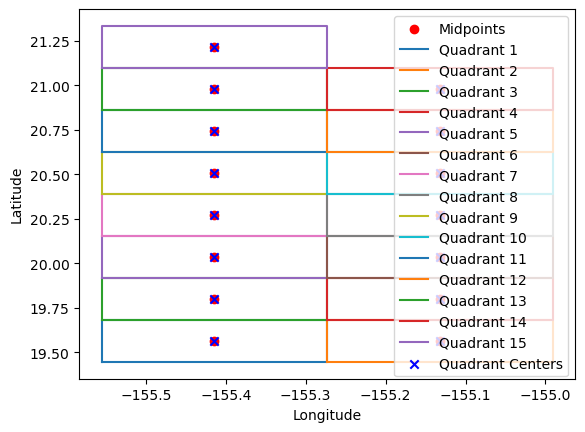

In [9]:
import matplotlib.pyplot as plt
from shapely.geometry import Point

def plot_quadrants_and_centers(midpoints, quadrants, center_points):
    # Extract coordinates for plotting
    lons, lats = zip(*midpoints)
    center_lons, center_lats = zip(*[(point.x, point.y) for point in center_points])
    
    # Plot midpoints
    plt.scatter(lons, lats, c='red', marker='o', label='Midpoints')

    # Plot quadrants
    for i, quadrant in enumerate(quadrants):
        quad_min_lon, quad_max_lon, quad_min_lat, quad_max_lat = quadrant
        quad_lons = [quad_min_lon, quad_max_lon, quad_max_lon, quad_min_lon, quad_min_lon]
        quad_lats = [quad_min_lat, quad_min_lat, quad_max_lat, quad_max_lat, quad_min_lat]
        plt.plot(quad_lons, quad_lats, label=f'Quadrant {i + 1}')

    # Plot center points
    plt.scatter(center_lons, center_lats, c='blue', marker='x', label='Quadrant Centers')

    # Set labels and legend
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    
    # Show the plot
    plt.show()

# Assuming total_bbox is defined somewhere
total_bbox = (min_lon, min_lat, max_lon, max_lat)

# Generate midpoints and quadrants
midpoints, quadrants = generate_quadrants(*total_bbox, 15)

# Calculate center points in all quadrants
center_points = calculate_center_points(quadrants)

# Plot the corrected quadrants and centers
plot_quadrants_and_centers(midpoints, quadrants, center_points)


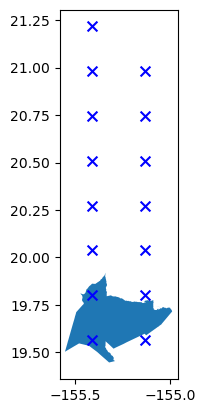

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Assuming total_bbox is defined somewhere
total_bbox = (min_lon, min_lat, max_lon, max_lat)

# Generate midpoints and quadrants
midpoints, quadrants = generate_quadrants(*total_bbox, 15)

# Calculate center points in all quadrants
center_points = calculate_center_points(quadrants)

# Create a GeoDataFrame for the center points
gdf_center_points = gpd.GeoDataFrame(geometry=center_points)

# Load the base GeoJSON file (replace 'your_geojson_file.geojson' with the actual file path)
base_map = gpd.read_file('../data/boundaries/hilo.geojson')

# Plot the base map
base_map.plot()

# Plot the center points on top of the base map
gdf_center_points.plot(ax=plt.gca(), marker='x', color='blue', markersize=50)

# Show the plot
plt.show()
